# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_169  P31944                            18.595
Sample_123  F6SYP7;P98153;P98153-2;P98153-3   15.459
Sample_018  D6RJG0;Q9Y6N8                     15.990
Sample_119  A0A0B4J2C3;P13693;Q5W0H4          10.975
Sample_188  A9UJN9;A9UJP0;P01127;P01127-2     18.782
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                                    
Sample_090  P10745                                               12.091
Sample_146  J3KNV4;Q13683;Q13683-10;Q13683-3;Q13683-7;Q13683-9   15.433
Sample_011  Q495W5;Q495W5-2                                      11.345
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.806
            A0A075B6Q5                 12.739
            A0A075B6R2                 11.135
            A0A075B6S5                 12.653
            A0A087WSY4                 12.989
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.817
            Q9UI40;Q9UI40-2            12.380
            Q9UIW2                     12.674
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.300
            Q9UP79                     11.759
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.796,15.050,16.842,19.863,13.531,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.641,19.067,...,15.528,15.576,12.264,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.086,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.458,17.705,17.039,12.699,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.126,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.881,15.345,17.084,18.708,14.249,19.433,10.960,8.532
Sample_207,15.739,16.877,15.469,16.898,11.704,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.500,12.473,13.030,13.483,13.395,12.895,13.455,13.792,13.989,13.023
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.220,19.067,16.127,...,13.138,13.447,13.473,13.381,12.421,13.669,12.566,12.752,13.050,13.300
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.401,13.267,11.995,11.707,13.173,12.833,11.794,12.544,12.403,14.155
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.025,13.198,12.658,12.555,12.676,12.575,12.881,12.833,12.449,12.906
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.515,10.868,12.378,12.496,13.237,13.590,12.937,13.492,13.472,12.438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.096,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 314.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.74it/s]

100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

100%|██████████| 3/3 [00:00<00:00,  6.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.50it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.15it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.00it/s]

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.62it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.06it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.34it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.43it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.28it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.19it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.36it/s]

100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.04it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.90it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.07it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.69it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.90it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.09it/s]

100%|██████████| 8/8 [00:01<00:00,  3.96it/s]

100%|██████████| 8/8 [00:01<00:00,  4.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.19it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.73it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.43it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.45it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.16it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.99it/s]

100%|██████████| 9/9 [00:02<00:00,  4.07it/s]

100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.54it/s]

 30%|███       | 3/10 [00:00<00:01,  6.04it/s]

 40%|████      | 4/10 [00:00<00:01,  5.16it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.75it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.59it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.52it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

 90%|█████████ | 9/10 [00:01<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  3.09it/s]

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.15it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.51it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.01it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.64it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.37it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.15it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.50it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.80it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.31it/s]

100%|██████████| 11/11 [00:02<00:00,  2.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.92it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.01it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.07it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.70it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.55it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.98it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.48it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.03it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.70it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.48it/s]

100%|██████████| 12/12 [00:03<00:00,  2.39it/s]

100%|██████████| 12/12 [00:03<00:00,  3.25it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.95it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.96it/s]

 31%|███       | 4/13 [00:00<00:01,  5.35it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.90it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.68it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.89it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.38it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.04it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.62it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.52it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.39it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.74it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.64it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.70it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.24it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.98it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.48it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.42it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.37it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:02<00:01,  2.67it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.58it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.55it/s]

100%|██████████| 14/14 [00:04<00:00,  2.49it/s]

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.02it/s]

 20%|██        | 3/15 [00:00<00:01,  6.23it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.42it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.90it/s]

 40%|████      | 6/15 [00:01<00:01,  4.74it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.67it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.25it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.54it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.07it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  2.82it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.54it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.67it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.64it/s]

100%|██████████| 15/15 [00:04<00:00,  2.51it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.047 0.023          0.581 0.447       0.078   
2             0.004 0.003      0.046 0.021          0.752 0.090       0.683   
3             0.005 0.004      0.058 0.020          0.742 0.095       0.668   
4             0.004 0.004      0.041 0.014          0.744 0.100       0.667   
5             0.005 0.004      0.047 0.023          0.727 0.112       0.684   
6             0.004 0.001      0.036 0.009          0.776 0.094       0.793   
7             0.004 0.002      0.039 0.016          0.772 0.098       0.787   
8             0.005 0.005      0.054 0.026          0.778 0.094       0.793   
9             0.007 0.006      0.068 0.024          0.780 0.093       0.791   
10            0.007 0.007      0.060 0.024          0.782 0.090       0.802   
11            0.006 0.006      0.061 0.027          0.811 0.080       0.818   
12            0.007 0.006      0.052 0.025          0.801 0.084       0.806   
13            0.005 0.004      0.047 0.024          0.804 0.088       0.789   
14            0.005 0.003      0.053 0.022          0.798 0.084       0.787   
15            0.006 0.006      0.048 0.019          0.801 0.091       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.132 0.126                  0.533 0.038        0.840   
2          0.102   0.709 0.068                  0.756 0.053        0.839   
3          0.108   0.696 0.074                  0.745 0.057        0.834   
4          0.106   0.695 0.072                  0.745 0.055        0.831   
5          0.102   0.697 0.079                  0.743 0.064        0.834   
6          0.110   0.778 0.075                  0.810 0.061        0.894   
7          0.112   0.773 0.078                  0.805 0.065        0.892   
8          0.107   0.780 0.073                  0.811 0.063        0.894   
9          0.106   0.780 0.074                  0.811 0.063        0.892   
10         0.107   0.786 0.073                  0.817 0.062        0.892   
11         0.097   0.811 0.066                  0.838 0.058        0.905   
12         0.098   0.799 0.069                  0.828 0.058        0.904   
13         0.095   0.792 0.068                  0.822 0.057        0.903   
14         0.095   0.788 0.068                  0.819 0.057        0.901   
15         0.093   0.794 0.069                  0.823 0.059        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.806 0.083        210.000 0.000  
2          0.057                  0.779 0.088        210.000 0.000  
3          0.058                  0.772 0.089        210.000 0.000  
4          0.058                  0.771 0.089        210.000 0.000  
5          0.060                  0.777 0.082        210.000 0.000  
6          0.047                  0.876 0.054        210.000 0.000  
7          0.047                  0.873 0.055        210.000 0.000  
8          0.048                  0.874 0.055        210.000 0.000  
9          0.048                  0.870 0.055        210.000 0.000  
10         0.047                  0.870 0.054        210.000 0.000  
11         0.046                  0.883 0.057        210.000 0.000  
12         0.047                  0.886 0.055        210.000 0.000  
13         0.049                  0.886 0.055        210.000 0.000  
14         0.049                  0.884 0.055        210.000 0.000  
15         0.050                  0.892 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 474.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.82it/s]

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.07it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.71it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.30it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.04it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.79it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.76it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.41it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.36it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.82it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.92it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:02<00:00,  3.75it/s]

100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.29it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.24it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.97it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.71it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.61it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.63it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.73it/s]

100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  3.90it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.26it/s]

 30%|███       | 3/10 [00:00<00:01,  5.36it/s]

 40%|████      | 4/10 [00:00<00:01,  4.55it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.02it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.75it/s]

 70%|███████   | 7/10 [00:01<00:01,  2.84it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.49it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.84it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.87it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.07it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.88it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.65it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.44it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  2.71it/s]

100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.50it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.25it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.62it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.28it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.11it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.00it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.66it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.39it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.92it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:03<00:00,  2.45it/s]

100%|██████████| 12/12 [00:03<00:00,  3.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.83it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.14it/s]

 31%|███       | 4/13 [00:01<00:03,  2.72it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.84it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.01it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.12it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.00it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.23it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.36it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.43it/s]

100%|██████████| 13/13 [00:04<00:00,  3.50it/s]

100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.11it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.38it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.89it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.55it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.41it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.09it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.71it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.73it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.20it/s]

100%|██████████| 14/14 [00:05<00:00,  2.10it/s]

100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.90it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.91it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.43it/s]

 40%|████      | 6/15 [00:02<00:04,  2.13it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.99it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.85it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.93it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.96it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.02it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.14it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.17it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.22it/s]

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]

100%|██████████| 15/15 [00:06<00:00,  2.27it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.048 0.023          0.769 0.339       0.124   
2             0.005 0.006      0.049 0.020          0.625 0.126       0.471   
3             0.006 0.005      0.064 0.028          0.816 0.079       0.719   
4             0.003 0.000      0.037 0.008          0.809 0.079       0.767   
5             0.005 0.005      0.049 0.021          0.806 0.080       0.757   
6             0.003 0.000      0.036 0.008          0.796 0.089       0.753   
7             0.004 0.004      0.038 0.011          0.821 0.087       0.786   
8             0.004 0.002      0.037 0.009          0.820 0.089       0.783   
9             0.003 0.000      0.034 0.007          0.817 0.086       0.839   
10            0.006 0.005      0.057 0.019          0.811 0.083       0.836   
11            0.005 0.004      0.045 0.017          0.826 0.073       0.840   
12            0.005 0.004      0.043 0.015          0.831 0.077       0.839   
13            0.006 0.005      0.049 0.015          0.835 0.076       0.832   
14            0.006 0.006      0.056 0.030          0.832 0.075       0.832   
15            0.004 0.003      0.038 0.013          0.835 0.075       0.842   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.205 0.131                  0.554 0.043        0.848   
2          0.117   0.527 0.097                  0.627 0.064        0.706   
3          0.106   0.760 0.072                  0.799 0.057        0.900   
4          0.110   0.783 0.072                  0.816 0.060        0.901   
5          0.115   0.776 0.078                  0.811 0.063        0.897   
6          0.109   0.769 0.079                  0.805 0.064        0.894   
7          0.104   0.798 0.074                  0.829 0.062        0.901   
8          0.108   0.796 0.076                  0.827 0.063        0.899   
9          0.102   0.824 0.073                  0.849 0.063        0.911   
10         0.105   0.819 0.071                  0.845 0.062        0.910   
11         0.092   0.830 0.064                  0.855 0.055        0.912   
12         0.083   0.831 0.057                  0.855 0.048        0.916   
13         0.085   0.830 0.061                  0.855 0.052        0.916   
14         0.085   0.829 0.060                  0.853 0.051        0.915   
15         0.085   0.835 0.056                  0.859 0.048        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.823 0.088        210.000 0.000  
2          0.080                  0.657 0.097        210.000 0.000  
3          0.048                  0.880 0.057        210.000 0.000  
4          0.050                  0.881 0.056        210.000 0.000  
5          0.052                  0.878 0.059        210.000 0.000  
6          0.053                  0.874 0.059        210.000 0.000  
7          0.054                  0.885 0.062        210.000 0.000  
8          0.055                  0.884 0.062        210.000 0.000  
9          0.050                  0.900 0.053        210.000 0.000  
10         0.050                  0.900 0.050        210.000 0.000  
11         0.051                  0.902 0.056        210.000 0.000  
12         0.049                  0.908 0.052        210.000 0.000  
13         0.049                  0.909 0.053        210.000 0.000  
14         0.050                  0.908 0.053        210.000 0.000  
15         0.047                  0.905 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1030.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 39.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.08it/s]

100%|██████████| 3/3 [00:00<00:00, 16.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.93it/s]

100%|██████████| 4/4 [00:00<00:00, 18.96it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.55it/s]

100%|██████████| 5/5 [00:00<00:00, 15.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.10it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.01it/s]

100%|██████████| 6/6 [00:00<00:00, 15.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.87it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.75it/s]

100%|██████████| 7/7 [00:00<00:00, 15.57it/s]

100%|██████████| 7/7 [00:00<00:00, 15.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 28.61it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 19.06it/s]

100%|██████████| 8/8 [00:00<00:00, 17.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.94it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.09it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.33it/s]

100%|██████████| 9/9 [00:00<00:00, 13.41it/s]

100%|██████████| 9/9 [00:00<00:00, 13.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.09it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.40it/s]

 70%|███████   | 7/10 [00:00<00:00, 15.80it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.42it/s]

100%|██████████| 10/10 [00:00<00:00, 14.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.39it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.14it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.19it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.69it/s]

100%|██████████| 11/11 [00:00<00:00, 12.73it/s]

100%|██████████| 11/11 [00:00<00:00, 13.25it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.25it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.56it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.79it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.21it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.72it/s]

100%|██████████| 12/12 [00:00<00:00, 13.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.89it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.31it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.88it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.51it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.72it/s]

100%|██████████| 13/13 [00:00<00:00, 13.48it/s]

100%|██████████| 13/13 [00:00<00:00, 13.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.90it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.85it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.56it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.11it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.34it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.38it/s]

100%|██████████| 14/14 [00:00<00:00, 14.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.65it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.94it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.73it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.43it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.25it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.54it/s]

100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

100%|██████████| 15/15 [00:01<00:00, 12.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.006      0.050 0.021          0.355 0.459       0.029   
2             0.003 0.001      0.032 0.006          0.315 0.417       0.042   
3             0.003 0.002      0.038 0.012          0.683 0.294       0.174   
4             0.004 0.002      0.035 0.004          0.642 0.224       0.206   
5             0.004 0.002      0.053 0.020          0.608 0.157       0.313   
6             0.003 0.001      0.032 0.006          0.588 0.161       0.303   
7             0.004 0.003      0.043 0.016          0.553 0.139       0.307   
8             0.003 0.000      0.031 0.005          0.517 0.139       0.299   
9             0.004 0.004      0.038 0.012          0.497 0.147       0.298   
10            0.004 0.001      0.038 0.007          0.496 0.113       0.326   
11            0.005 0.004      0.047 0.015          0.479 0.108       0.317   
12            0.004 0.000      0.035 0.002          0.571 0.079       0.467   
13            0.005 0.004      0.046 0.016          0.567 0.105       0.474   
14            0.004 0.000      0.034 0.001          0.585 0.098       0.475   
15            0.004 0.000      0.037 0.011          0.565 0.099       0.470   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.041   0.052 0.072                  0.510 0.021        0.721   
2          0.060   0.070 0.095                  0.508 0.025        0.687   
3          0.113   0.264 0.153                  0.562 0.054        0.655   
4          0.092   0.305 0.119                  0.561 0.056        0.620   
5          0.089   0.404 0.095                  0.577 0.054        0.612   
6          0.097   0.388 0.097                  0.567 0.053        0.600   
7          0.099   0.382 0.094                  0.554 0.056        0.584   
8          0.098   0.369 0.097                  0.542 0.058        0.564   
9          0.100   0.360 0.097                  0.532 0.058        0.559   
10         0.082   0.385 0.073                  0.535 0.054        0.553   
11         0.084   0.374 0.079                  0.528 0.054        0.541   
12         0.117   0.505 0.086                  0.604 0.052        0.649   
13         0.108   0.507 0.084                  0.600 0.060        0.649   
14         0.078   0.517 0.060                  0.609 0.049        0.650   
15         0.086   0.506 0.070                  0.598 0.056        0.649   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.672 0.078        210.000 0.000  
2          0.102                  0.632 0.105        210.000 0.000  
3          0.091                  0.630 0.094        210.000 0.000  
4          0.081                  0.588 0.092        210.000 0.000  
5          0.071                  0.587 0.077        210.000 0.000  
6          0.072                  0.570 0.078        210.000 0.000  
7          0.078                  0.548 0.077        210.000 0.000  
8          0.081                  0.529 0.079        210.000 0.000  
9          0.082                  0.511 0.075        210.000 0.000  
10         0.076                  0.509 0.077        210.000 0.000  
11         0.073                  0.499 0.074        210.000 0.000  
12         0.065                  0.574 0.078        210.000 0.000  
13         0.065                  0.582 0.076        210.000 0.000  
14         0.069                  0.588 0.080        210.000 0.000  
15         0.070                  0.584 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,13,11
score_time,9,3,5
test_precision,11,15,3
test_recall,11,15,14
test_f1,11,15,14
test_balanced_accuracy,11,15,14
test_roc_auc,11,13,1
test_average_precision,15,13,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.57it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.24it/s]

 31%|███       | 4/13 [00:00<00:02,  4.50it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.10it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.03it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.90it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.74it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.59it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.41it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  2.96it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.81it/s]

100%|██████████| 13/13 [00:03<00:00,  2.62it/s]

100%|██████████| 13/13 [00:03<00:00,  3.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 917.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.63it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.87it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.36it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.00it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.72it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.52it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.52it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.52it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  3.63it/s]

100%|██████████| 11/11 [00:02<00:00,  4.38it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


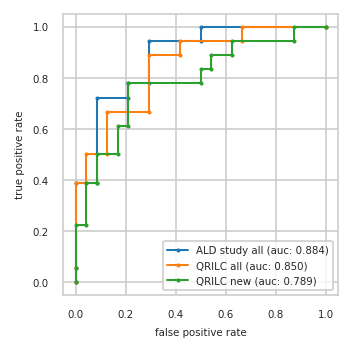

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.389     0.000 0.389     0.000 0.222
3          0.083 0.389     0.042 0.389     0.042 0.222
4          0.083 0.722     0.042 0.500     0.042 0.389
5          0.208 0.722     0.125 0.500     0.083 0.389
6          0.208 0.778     0.125 0.667     0.083 0.500
7          0.292 0.778     0.292 0.667     0.167 0.500
8          0.292 0.944     0.292 0.889     0.167 0.611
9          0.500 0.944     0.417 0.889     0.208 0.611
10         0.500 1.000     0.417 0.944     0.208 0.778
11         1.000 1.000     0.667 0.944     0.500 0.778
12           NaN   NaN     0.667 1.000     0.500 0.833
13           NaN   NaN     1.000 1.000     0.542 0.833
14           NaN   NaN       NaN   NaN     0.542 0.889
15           NaN   NaN       NaN   NaN     0.625 0.889
16           NaN   NaN       NaN   NaN     0.625 0.944
17           NaN   NaN       NaN   NaN     0.875 0.944
18           NaN   NaN       NaN   NaN     0.875 1.000
19           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,D6R956;P09936
1,Q9NRN5,P60709;P63261,None
2,P09486,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,None
3,P22676,P10636-2;P10636-6,None
4,P10636-2;P10636-6,P61981,None
5,P14174,A0A0A0MRJ7;P12259,None
6,P61981,P14174,None
7,Q9Y2T3;Q9Y2T3-3,P04075,None
8,P00338;P00338-3,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


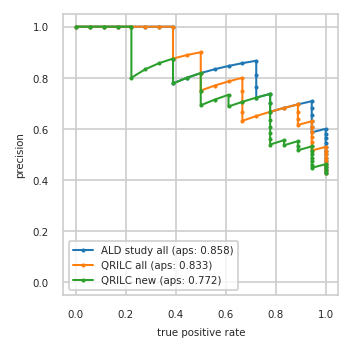

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.708 0.944     0.667 0.889     0.583 0.778
19         0.696 0.889     0.696 0.889     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.667 0.778     0.667 0.778     0.667 0.778
22         0.700 0.778     0.650 0.722     0.700 0.778
23         0.737 0.778     0.632 0.667     0.737 0.778
24         0.722 0.722     0.667 0.667     0.722 0.722
25         0.765 0.722     0.706 0.667     0.706 0.667
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.867 0.722     0.800 0.667     0.733 0.611
28         0.857 0.667     0.786 0.611     0.714 0.556
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.750 0.500
31         0.818 0.500     0.818 0.500     0.818 0.500
32         0.800 0.444     0.900 0.500     0.800 0.444
33         0.778 0.389     0.889 0.444     0.778 0.389
34         0.875 0.389     0.875 0.389     0.875 0.389
35         1.000 0.389     1.000 0.389     0.857 0.333
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     1.000 0.222
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


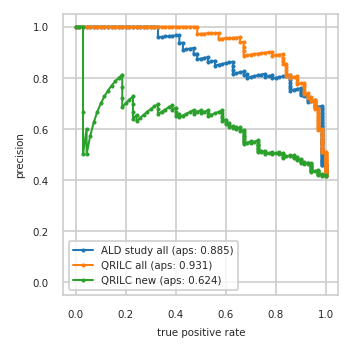

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


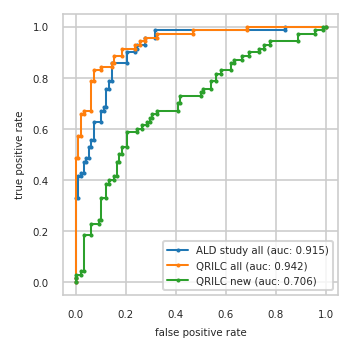

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}